# Importing Liberaries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pylab as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.4.1
GPU is NOT AVAILABLE


# Data Preprocessing

**Loading Data**

In [2]:
validation_dir = '/kaggle/input/cat-and-dogs/dataset/test_set'
train_dir = '/kaggle/input/cat-and-dogs/dataset/training_set'

BATCH_SIZE = 32
IMG_SIZE = (160,160)

In [3]:
train_dataset = image_dataset_from_directory(train_dir, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)

Found 8000 files belonging to 2 classes.


In [4]:
validation_dataset = image_dataset_from_directory(validation_dir, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)

Found 2000 files belonging to 2 classes.


**Displaying Some Data**

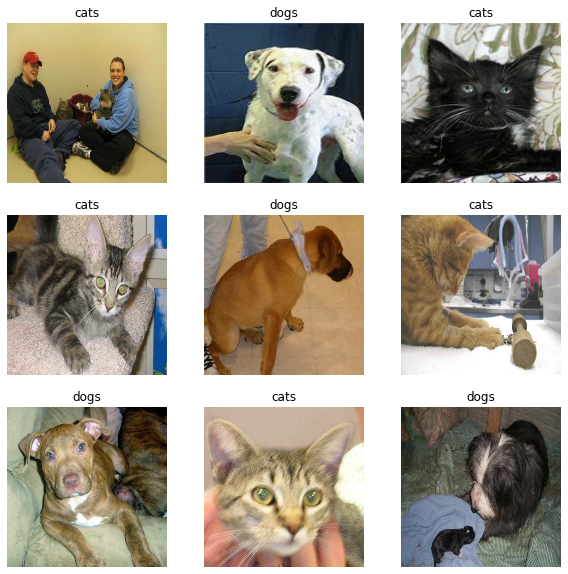

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize = (10,10))
for images,labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Creating Test Data Set in Training data**

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 51
Number of test batches: 12


**Configuring Dataset**

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

**Data Augmentation**

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

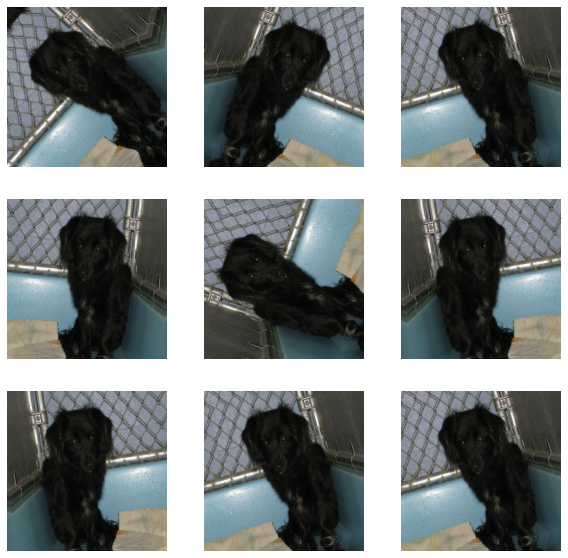

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

**Rescaling Pixel Values**

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5,offset = -1)

**Creating base model from the pre-trained convnets**

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# Feature Extraction

In [14]:
base_model.trainable = False

In [15]:
# Summary
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

**Add Classification Head**

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

**Compiling the Model**

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# Summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [21]:
len(model.trainable_variables)

2

# Training The Model

In [22]:
initial_epochs = 15
loss0, accuracy0 = model.evaluate(validation_dataset)

51/51 [==============================] - 25s 404ms/step - loss: 0.8726 - accuracy: 0.3978


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.41


In [24]:
history = model.fit(train_dataset,epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
250/250 [==============================] - 135s 526ms/step - loss: 0.5207 - accuracy: 0.7160 - val_loss: 0.2658 - val_accuracy: 0.9022
Epoch 2/15
250/250 [==============================] - 128s 510ms/step - loss: 0.2756 - accuracy: 0.8838 - val_loss: 0.1638 - val_accuracy: 0.9431
Epoch 3/15
250/250 [==============================] - 128s 512ms/step - loss: 0.2136 - accuracy: 0.9106 - val_loss: 0.1185 - val_accuracy: 0.9610
Epoch 4/15
250/250 [==============================] - 125s 498ms/step - loss: 0.1867 - accuracy: 0.9193 - val_loss: 0.1022 - val_accuracy: 0.9647
Epoch 5/15
250/250 [==============================] - 127s 506ms/step - loss: 0.1685 - accuracy: 0.9271 - val_loss: 0.0895 - val_accuracy: 0.9691
Epoch 6/15
250/250 [==============================] - 127s 506ms/step - loss: 0.1553 - accuracy: 0.9342 - val_loss: 0.0810 - val_accuracy: 0.9740
Epoch 7/15
250/250 [==============================] - 127s 507ms/step - loss: 0.1506 - accuracy: 0.9367 - val_loss: 0.0737 -

**Comparing Curves**

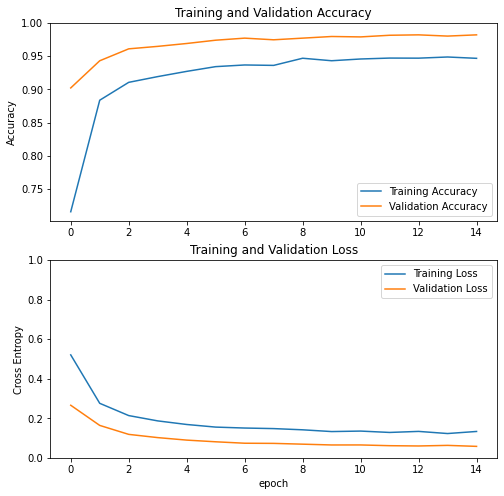

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning the Model

In [26]:
base_model.trainable = True

In [27]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [28]:
fine_tune_at = 80
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

# Compiling Tuned Model

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
# Summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [31]:
len(model.trainable_variables)

77

# Training on Tuned Model

In [32]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 15/40
250/250 [==============================] - 210s 819ms/step - loss: 0.1185 - accuracy: 0.9494 - val_loss: 0.0523 - val_accuracy: 0.9821
Epoch 16/40
250/250 [==============================] - 203s 809ms/step - loss: 0.0943 - accuracy: 0.9640 - val_loss: 0.0469 - val_accuracy: 0.9833
Epoch 17/40
250/250 [==============================] - 204s 814ms/step - loss: 0.0890 - accuracy: 0.9630 - val_loss: 0.0381 - val_accuracy: 0.9864
Epoch 18/40
250/250 [==============================] - 204s 813ms/step - loss: 0.0808 - accuracy: 0.9683 - val_loss: 0.0464 - val_accuracy: 0.9827
Epoch 19/40
250/250 [==============================] - 207s 825ms/step - loss: 0.0693 - accuracy: 0.9736 - val_loss: 0.0419 - val_accuracy: 0.9858
Epoch 20/40
250/250 [==============================] - 207s 822ms/step - loss: 0.0618 - accuracy: 0.9778 - val_loss: 0.0423 - val_accuracy: 0.9814
Epoch 21/40
250/250 [==============================] - 206s 822ms/step - loss: 0.0634 - accuracy: 0.9719 - val_loss: 0

**Comparing Curves**

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

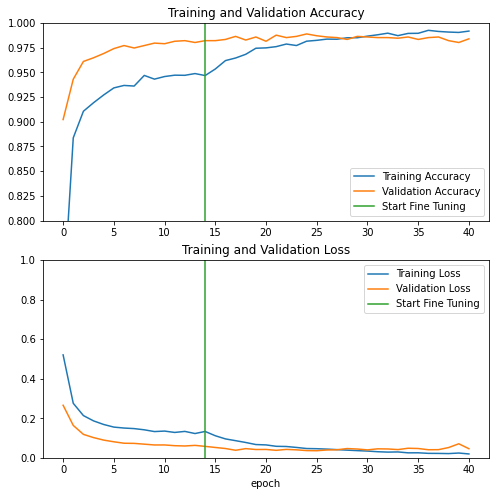

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluating and Predicting

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 5s 363ms/step - loss: 0.0285 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


Predictions:
 [0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1]
Labels:
 [0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1]


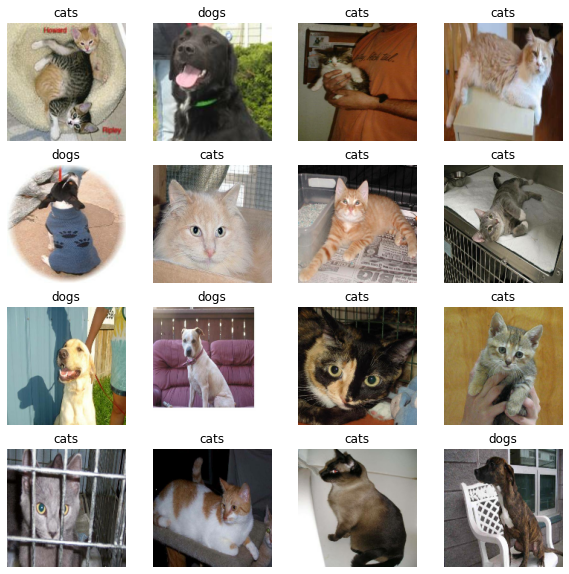

In [36]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Summary

* **Using a pre-trained model for feature extraction:** When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model:** To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.